# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# 한글 깨짐 문제 해결용
from matplotlib import font_manager, rc
plt.rcParams["axes.unicode_minus"] = False
path = "C:\Windows\Fonts\H2GTRM.TTF"
font_name = font_manager.FontProperties(fname=path).get_name()
rc("font", family=font_name)

# 1. Data

In [3]:
rg3 = pd.read_csv("../data/processed/labeled_data_rg3.csv", parse_dates=True)

In [4]:
rg3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TimeStamp                 1256 non-null   object 
 1   _id                       1256 non-null   object 
 2   Filling_Time              1256 non-null   float64
 3   Barrel_Temperature_2      1256 non-null   float64
 4   Max_Injection_Pressure    1256 non-null   float64
 5   Barrel_Temperature_4      1256 non-null   float64
 6   Cushion_Position          1256 non-null   float64
 7   Barrel_Temperature_5      1256 non-null   float64
 8   Mold_Temperature_4        1256 non-null   float64
 9   Injection_Time            1256 non-null   float64
 10  Max_Injection_Speed       1256 non-null   float64
 11  Barrel_Temperature_3      1256 non-null   float64
 12  Average_Screw_RPM         1256 non-null   float64
 13  Hopper_Temperature        1256 non-null   float64
 14  Plastici

# 2. 학습/평가 데이터 분리를 위한 데이터 전처리

In [5]:
numerical_features = [x for x in rg3.columns if np.dtype(rg3[x]) == "float64"]

In [6]:
rg3["PassOrFail"].value_counts()

0    1224
1      32
Name: PassOrFail, dtype: int64

In [7]:
# 양품
rg3_Y = rg3[rg3["PassOrFail"] == 0]
print("rg3의 양품 개수:", len(rg3_Y))

rg3의 양품 개수: 1224


In [8]:
# 불량
rg3_N = rg3[rg3["PassOrFail"] == 1]
print("rg3의 불량 개수:", len(rg3_N))

rg3의 불량 개수: 32


**잡음 제거 오토인코더 모델에 학습시킬 데이터의 형태는 클래스 변수가 없어야 하므로 변수 "PassOrFail"을 제거함

In [9]:
# Data for passed parts
rg3_Y = rg3_Y[numerical_features]
# Data for Failed parts
rg3_N = rg3_N[numerical_features]

#### 학습/평가 데이터 분리 (6:4 비율)

In [10]:
rg3_Y.shape

(1224, 23)

In [11]:
rg3_train_Y, rg3_test_Y = train_test_split(rg3_Y, test_size=0.1)

# 평가 데이터 (불량)
rg3_test_N = rg3_N

print(f"rg3 학습 데이터 (양품) 개수: {len(rg3_train_Y)}")
print(f"rg3 평가 데이터 (양품) 개수: {len(rg3_test_Y)}")
print(f"rg3 평가 데이터 (불량) 개수: {len(rg3_test_N)}")

rg3 학습 데이터 (양품) 개수: 1101
rg3 평가 데이터 (양품) 개수: 123
rg3 평가 데이터 (불량) 개수: 32


In [12]:
# MinMaxscaler를 통한 데이터 정규화

scaler = StandardScaler()

rg3_train_Y = scaler.fit_transform(rg3_train_Y)
rg3_test_Y = scaler.transform(rg3_test_Y)
rg3_test_N = scaler.transform(rg3_test_N)

# 3. Mahalanobis Distance

In [13]:
def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data, axis=0)
    if not cov:
        cov = np.cov(data.T)
        # cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()  # Can't understand why .diagonal() is used

In [14]:
class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1] - 1) # df = degree of freedom
        print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

# 4. 임계값 정의

In [15]:
clf = MahalanobisOneclassClassifier(rg3_train_Y, significance_level=0.1)

Critical value is:  30.813282343953027


In [16]:
threshold = clf.critical_value

# 5. 데이터 각각의 예측값과 복원 오차 확인

## 5.1. 평가 데이터 (양품) 대상 모델 성능 검증 

In [17]:
# 예측값
rg3_MD_Y = clf.predict_proba(rg3_test_Y)

In [18]:
rg3_MD_Y.shape

(123,)

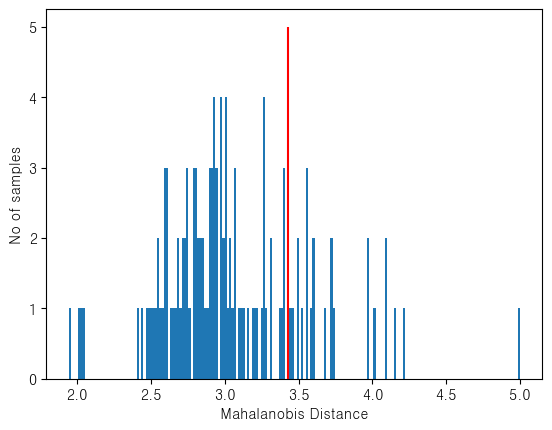

In [19]:
# 시각화

plt.hist(np.log(rg3_MD_Y), bins=200)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [20]:
# 불량으로 판단한 데이터 확인

rg3_test_Y_anomalies = rg3_MD_Y > threshold
print("불량 개수: ", np.sum(rg3_test_Y_anomalies))
print("정확도: ", (rg3_test_Y.shape[0]-np.sum(rg3_test_Y_anomalies))/rg3_test_Y.shape[0])

불량 개수:  24
정확도:  0.8048780487804879


## 5.2. 평가 데이터 (불량) 대상 모델 성능 검증 

In [21]:
# 예측값
rg3_MD_N = clf.predict_proba(rg3_test_N)

In [22]:
rg3_MD_N

array([ 24.83215836,  15.58041701,  16.16044695,  23.46360247,
        19.2402382 ,  13.68875966,  19.52539164,  15.03613936,
        22.77484979,  14.98041504,  21.74974947,  14.47753759,
        16.69126884,  18.58449282,  17.01160266,  26.35725538,
        22.95397805,  32.44740119,  13.76060442,  16.45761163,
         7.49904115,  16.20866275,  16.68174278,  17.50213577,
        30.00673157, 169.73061697,  56.0024358 ,  54.06884345,
        58.653129  ,  35.79749596,  38.95000298,  39.49700499])

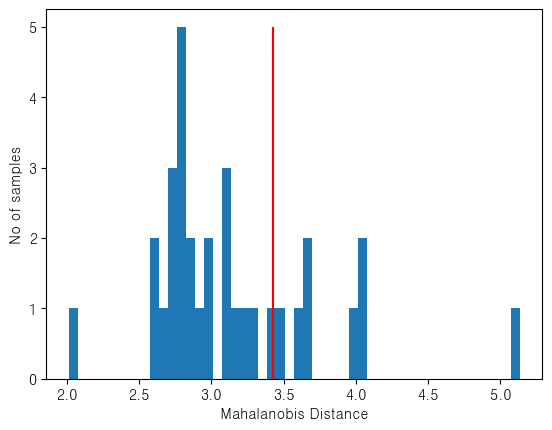

In [23]:
# 시각화

plt.hist(np.log(rg3_MD_N), bins=50)
plt.xlabel("Mahalanobis Distance")
plt.ylabel("No of samples")
plt.vlines(np.log(threshold), 0, 5, color="red")
plt.show();

In [24]:
# 불량으로 판단한 데이터 확인

rg3_test_N_anomalies = rg3_MD_N > threshold
print("불량 개수: ", np.sum(rg3_test_N_anomalies))
print("정확도: ", np.sum(rg3_test_N_anomalies)/rg3_test_N.shape[0])

불량 개수:  8
정확도:  0.25


# 6. 결과 분석

In [25]:
# 평가 데이터의 실제값

rg3_true = np.concatenate(
    [np.zeros(len(rg3_test_Y_anomalies)), np.ones(len(rg3_test_N_anomalies))]
)

In [26]:
rg3_true.shape

(155,)

In [27]:
# 평가 데이터의 예측값

rg3_prediction = np.concatenate(
    [rg3_test_Y_anomalies, rg3_test_N_anomalies]
)

In [28]:
rg3_prediction.shape

(155,)

In [29]:
confusion_matrix(rg3_true, rg3_prediction)

array([[99, 24],
       [24,  8]], dtype=int64)

In [30]:
print(classification_report(rg3_true, rg3_prediction))

              precision    recall  f1-score   support

         0.0       0.80      0.80      0.80       123
         1.0       0.25      0.25      0.25        32

    accuracy                           0.69       155
   macro avg       0.53      0.53      0.53       155
weighted avg       0.69      0.69      0.69       155

